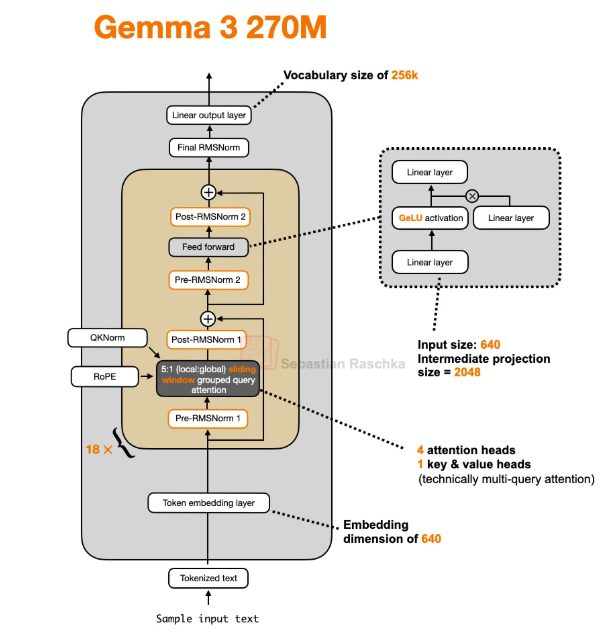

In [1]:
!pip install -r https://raw.githubusercontent.com/p1kalys/Gemma-3-270M/refs/heads/main/requirements.txt --quiet

In [2]:
from importlib.metadata import version

pkgs = [
    "huggingface_hub",  # to download pretrained weights
    "tokenizers",       # to implement the tokenizer
    "torch",            # to implement the model
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

huggingface_hub version: 0.34.4
tokenizers version: 0.21.4
torch version: 2.8.0+cu126


In [3]:
USE_INSTRUCT_MODEL = True

# **1. Architecture**

In [4]:
import torch
import torch.nn as nn

# Applies non linear transformation to the input tensor using two parallel linear layers, GELU (Guassian Error Linear Unit) activation function and a final linear layer to project output back to the original embedding dimension
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
    self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
    self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)

  def forward(self, x):
    x_fc1 = self.fc1(x)
    x_fc2 = self.fc2(x)
    x = nn.functional.gelu(x_fc1, approximate="tanh") * x_fc2
    return self.fc3(x)

In [5]:
# Normalizes the output of layers in the Gemma model
class RMSNorm(nn.Module):
  def __init__(self, emb_dim, eps=1e-6, bias=False):
    super().__init__()
    self.eps = eps
    # Gemma3 stores zero-centered weights and uses (1 + weight) during forward
    self.scale = nn.Parameter(torch.zeros(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim)) if bias else None

  def forward(self, x):
    # Match HF Gemma3: compute norm in float32, then scale by (1 + w)
    input_dtype = x.dtype
    x_f = x.float()
    var = x_f.pow(2).mean(dim=-1, keepdim=True)
    x_norm = x_f * torch.rsqrt(var + self.eps)
    out = x_norm * (1.0 + self.scale.float())

    if self.shift is not None:
      out = out + self.shift.float()

    return out.to(input_dtype)

In [6]:
# Calculate Rotary Position Embeddings (RoPE) - injects positional information into the attention mechanism of a transformer model
def compute_rope_params(head_dim, theta_base=10_000, context_length=4096, dtype=torch.float32):
  assert head_dim % 2 == 0, "Embedding dimension must be even"

  # Compute the inverse frequencies
  inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2, dtype=dtype)[: (head_dim // 2)].float() / head_dim))

  # Generate position indices
  positions = torch.arange(context_length, dtype=dtype)

  # Compute the angles
  angles = positions[:, None] * inv_freq[None, :]  # Shape: (context_length, head_dim // 2)

  # Expand angles to match the head_dim
  angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)

  # Precompute sine and cosine
  cos = torch.cos(angles)
  sin = torch.sin(angles)

  return cos, sin

In [7]:
# Applying RoPE to input tensor `x`
def apply_rope(x, cos, sin):
  # x: (batch_size, num_heads, seq_len, head_dim)
  batch_size, num_heads, seq_len, head_dim = x.shape
  assert head_dim % 2 == 0, "Head dimension must be even"

  # Split x into first half and second half
  x1 = x[..., : head_dim // 2]  # First half
  x2 = x[..., head_dim // 2 :]  # Second half

  # Adjust sin and cos shapes
  cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
  sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

  # Apply the rotary transformation
  rotated = torch.cat((-x2, x1), dim=-1)
  x_rotated = (x * cos) + (rotated * sin)

  # It's ok to use lower-precision after applying cos and sin rotation
  return x_rotated.to(dtype=x.dtype)

In [8]:
# GQA - an optimization of standard multi-head attention which is the grouping of key and value heads to reduce computation.
class GroupedQueryAttention(nn.Module):
  def __init__(self, d_in, num_heads, num_kv_groups, head_dim=None, qk_norm=False, query_pre_attn_scalar=None, dtype=None):
    super().__init__()
    assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

    self.num_heads = num_heads
    self.num_kv_groups = num_kv_groups
    self.group_size = num_heads // num_kv_groups

    if head_dim is None:
      assert d_in % num_heads == 0, "`d_in` must be divisible by `num_heads` if `head_dim` is not set"
      head_dim = d_in // num_heads

    self.head_dim = head_dim
    self.d_out = num_heads * head_dim

    self.W_query = nn.Linear(d_in, self.d_out, bias=False, dtype=dtype)
    self.W_key = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)
    self.W_value = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)

    self.out_proj = nn.Linear(self.d_out, d_in, bias=False, dtype=dtype)

    if qk_norm:
      self.q_norm = RMSNorm(head_dim, eps=1e-6)
      self.k_norm = RMSNorm(head_dim, eps=1e-6)
    else:
      self.q_norm = self.k_norm = None

    if query_pre_attn_scalar is not None:
      self.scaling = (query_pre_attn_scalar) ** -0.5
    else:
      self.scaling = (head_dim) ** -0.5


  def forward(self, x, mask, cos, sin):
    b, num_tokens, _ = x.shape

    # Apply projections
    queries = self.W_query(x)  # (b, num_tokens, num_heads * head_dim)
    keys = self.W_key(x)       # (b, num_tokens, num_kv_groups * head_dim)
    values = self.W_value(x)   # (b, num_tokens, num_kv_groups * head_dim)

    # Reshape
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
    keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)
    values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)

    # Optional normalization
    if self.q_norm:
      queries = self.q_norm(queries)
    if self.k_norm:
      keys = self.k_norm(keys)

    # Apply RoPE
    queries = apply_rope(queries, cos, sin)
    keys = apply_rope(keys, cos, sin)

    # Expand K and V to match number of heads
    keys = keys.repeat_interleave(self.group_size, dim=1)
    values = values.repeat_interleave(self.group_size, dim=1)

    # Scale queries
    queries = queries * self.scaling

    # Attention
    attn_scores = queries @ keys.transpose(2, 3)
    attn_scores = attn_scores.masked_fill(mask, -torch.inf)
    attn_weights = torch.softmax(attn_scores, dim=-1)

    context = (attn_weights @ values).transpose(1, 2).reshape(b, num_tokens, self.d_out)
    return self.out_proj(context)

In [9]:
# TransformerBlock processes the input through a sequence of normalization, attention, residual connection, normalization, feed-forward, and another residual connection.
class TransformerBlock(nn.Module):
  def __init__(self, cfg: dict, attn_type: str):
    super().__init__()
    self.attn_type = attn_type
    self.att = GroupedQueryAttention(
        d_in=cfg["emb_dim"],
        num_heads=cfg["n_heads"],
        num_kv_groups=cfg["n_kv_groups"],
        head_dim=cfg["head_dim"],
        qk_norm=cfg["qk_norm"],
        query_pre_attn_scalar=cfg["query_pre_attn_scalar"],
        dtype=cfg["dtype"])
    self.ff = FeedForward(cfg)
    self.input_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
    self.post_attention_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
    self.pre_feedforward_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
    self.post_feedforward_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)

  def forward(self, x, mask_global, mask_local, cos_global, sin_global, cos_local, sin_local):
    # Shortcut connection for attention block
    shortcut = x
    x = self.input_layernorm(x)

    if self.attn_type == "sliding_attention":
      attn_mask = mask_local
      cos = cos_local
      sin = sin_local
    else:
      attn_mask = mask_global
      cos = cos_global
      sin = sin_global

    x_attn = self.att(x, attn_mask, cos, sin)
    x_attn = self.post_attention_layernorm(x_attn)
    x = shortcut + x_attn

    # Shortcut connection for feed forward block
    shortcut = x
    x_ffn = self.pre_feedforward_layernorm(x)
    x_ffn = self.ff(x_ffn)
    x_ffn = self.post_feedforward_layernorm(x_ffn)
    x = shortcut + x_ffn
    return x

In [10]:
# Orchestrates the flow of data through the entire network, applying token embeddings, multiple transformer blocks with different attention mechanisms and masking, final normalization, and an output head to produce the final token logits.
class Gemma3Model(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    assert cfg["layer_types"] is not None and len(cfg["layer_types"]) == cfg["n_layers"]

    # Main model parameters
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

    self.blocks = nn.ModuleList([
        TransformerBlock(cfg, attn_type)for attn_type in cfg["layer_types"]
    ])

    self.final_norm = RMSNorm(cfg["emb_dim"], eps=1e-6)
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])
    self.cfg = cfg

    # Reusuable utilities
    cos_local, sin_local = compute_rope_params(
        head_dim=cfg["head_dim"],
        theta_base=cfg["rope_local_base"],
        context_length=cfg["context_length"],
        dtype=torch.float32,
    )
    cos_global, sin_global = compute_rope_params(
        head_dim=cfg["head_dim"],
        theta_base=cfg["rope_base"],
        context_length=cfg["context_length"],
        dtype=torch.float32,
    )
    self.register_buffer("cos_local", cos_local, persistent=False)
    self.register_buffer("sin_local", sin_local, persistent=False)
    self.register_buffer("cos_global", cos_global, persistent=False)
    self.register_buffer("sin_global", sin_global, persistent=False)

  def _create_masks(self, seq_len, device):
    ones = torch.ones((seq_len, seq_len), dtype=torch.bool, device=device)

    # mask_global (future is masked: j > i)
    #     j:  0 1 2 3 4 5 6 7
    #  i
    #     0:  0 1 1 1 1 1 1 1
    #     1:  0 0 1 1 1 1 1 1
    #     2:  0 0 0 1 1 1 1 1
    #     3:  0 0 0 0 1 1 1 1
    #     4:  0 0 0 0 0 1 1 1
    #     5:  0 0 0 0 0 0 1 1
    #     6:  0 0 0 0 0 0 0 1
    #     7:  0 0 0 0 0 0 0 0
    mask_global = torch.triu(ones, diagonal=1)

    # far_past (too far back is masked: i - j >= sliding_window)
    # where sliding_window = 4
    #     j:  0 1 2 3 4 5 6 7
    #  i
    #     0:  0 0 0 0 0 0 0 0
    #     1:  0 0 0 0 0 0 0 0
    #     2:  0 0 0 0 0 0 0 0
    #     3:  0 0 0 0 0 0 0 0
    #     4:  1 0 0 0 0 0 0 0
    #     5:  1 1 0 0 0 0 0 0
    #     6:  1 1 1 0 0 0 0 0
    #     7:  1 1 1 1 0 0 0 0
    far_past = torch.triu(ones, diagonal=self.cfg["sliding_window"]).T

    # Local (sliding_window) = future OR far-past
    # mask_local
    #     j:  0 1 2 3 4 5 6 7
    # i
    # 0:      0 1 1 1 1 1 1 1
    # 1:      0 0 1 1 1 1 1 1
    # 2:      0 0 0 1 1 1 1 1
    # 3:      0 0 0 0 1 1 1 1
    # 4:      1 0 0 0 0 1 1 1
    # 5:      1 1 0 0 0 0 1 1
    # 6:      1 1 1 0 0 0 0 1
    # 7:      1 1 1 1 0 0 0 0
    mask_local = mask_global | far_past
    return mask_global, mask_local

  def forward(self, input_ids):
    # Forward pass
    b, seq_len = input_ids.shape
    x = self.tok_emb(input_ids) * (self.cfg["emb_dim"] ** 0.5)
    mask_global, mask_local = self._create_masks(seq_len, x.device)

    for block in self.blocks:
      x = block(
          x,
          mask_global=mask_global,
          mask_local=mask_local,
          cos_global=self.cos_global,
          sin_global=self.sin_global,
          cos_local=self.cos_local,
          sin_local=self.sin_local,
      )

    x = self.final_norm(x)
    logits = self.out_head(x.to(self.cfg["dtype"]))
    return logits

# **2. Initialize model**

In [11]:
GEMMA3_CONFIG_270M = {
    "vocab_size": 262_144,
    "context_length": 32_768,
    "emb_dim": 640,
    "n_heads": 4,
    "n_layers": 18,
    "hidden_dim": 2048,
    "head_dim": 256,
    "qk_norm": True,
    "n_kv_groups": 1,
    "rope_local_base": 10_000.0,
    "rope_base": 1_000_000.0,
    "sliding_window": 512,
      "layer_types": [
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention"
    ],
    "dtype": torch.bfloat16,
    "query_pre_attn_scalar": 256,
}

In [12]:
torch.manual_seed(123)
model = Gemma3Model(GEMMA3_CONFIG_270M)

In [13]:
model

Gemma3Model(
  (tok_emb): Embedding(262144, 640)
  (blocks): ModuleList(
    (0-17): 18 x TransformerBlock(
      (att): GroupedQueryAttention(
        (W_query): Linear(in_features=640, out_features=1024, bias=False)
        (W_key): Linear(in_features=640, out_features=256, bias=False)
        (W_value): Linear(in_features=640, out_features=256, bias=False)
        (out_proj): Linear(in_features=1024, out_features=640, bias=False)
        (q_norm): RMSNorm()
        (k_norm): RMSNorm()
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=640, out_features=2048, bias=False)
        (fc2): Linear(in_features=640, out_features=2048, bias=False)
        (fc3): Linear(in_features=2048, out_features=640, bias=False)
      )
      (input_layernorm): RMSNorm()
      (post_attention_layernorm): RMSNorm()
      (pre_feedforward_layernorm): RMSNorm()
      (post_feedforward_layernorm): RMSNorm()
    )
  )
  (final_norm): RMSNorm()
  (out_head): Linear(in_features=640, out_features

In [14]:
model(torch.tensor([1, 2, 3]).unsqueeze(0))

tensor([[[ 0.7539,  0.1060,  0.4805,  ...,  0.9375,  0.4043, -0.2383],
         [-0.3418, -0.0576,  0.8984,  ..., -0.2432,  0.4629,  0.8242],
         [-0.2695, -0.3281,  0.4102,  ...,  0.8750, -0.9727,  0.9844]]],
       dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

# Account for weight tying
total_params_normalized = total_params - model.tok_emb.weight.numel()
print(f"\nTotal number of unique parameters: {total_params_normalized:,}")

Total number of parameters: 435,870,336

Total number of unique parameters: 268,098,176


In [16]:
def model_memory_size(model, input_dtype=torch.float32):
  total_params = 0
  total_grads = 0
  for param in model.parameters():
    # Calculate total number of elements per parameter
    param_size = param.numel()
    total_params += param_size
    # Check if gradients are stored for this parameter
    if param.requires_grad:
      total_grads += param_size

  # Calculate buffer size (non-parameters that require memory)
  total_buffers = sum(buf.numel() for buf in model.buffers())

  # Size in bytes = (Number of elements) * (Size of each element in bytes)
  # We assume parameters and gradients are stored in the same type as input dtype
  element_size = torch.tensor(0, dtype=input_dtype).element_size()
  total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

  # Convert bytes to gigabytes
  total_memory_gb = total_memory_bytes / (1024**3)

  return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 3.37 GB
bfloat16: 1.69 GB


In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device);

# **3. Load pretrained weights**

In [18]:
# Transfers the learned knowledge from a pretrained model to custom model implementation, allowing us to leverage the benefits of pretraining without training from scratch.
def load_weights_into_gemma(Gemma3Model, param_config, params):
  def assign(left, right, tensor_name="unknown"):
    if left.shape != right.shape:
      raise ValueError(
          f"Shape mismatch in tensor '{tensor_name}'. Left: {left.shape}, Right: {right.shape}"
      )
    return torch.nn.Parameter(right.clone().detach() if isinstance(right, torch.Tensor) else torch.tensor(right))

  # Embedding weights
  if "model.embed_tokens.weight" in params:
    model.tok_emb.weight = assign(
        model.tok_emb.weight,
        params["model.embed_tokens.weight"],
        "model.embed_tokens.weight",
    )

  # Iterate over transformer layers
  for l in range(param_config["n_layers"]):
    block = model.blocks[l]
    att = block.att
    # Attention projections
    att.W_query.weight = assign(
        att.W_query.weight,
        params[f"model.layers.{l}.self_attn.q_proj.weight"],
        f"model.layers.{l}.self_attn.q_proj.weight",
    )
    att.W_key.weight = assign(
        att.W_key.weight,
        params[f"model.layers.{l}.self_attn.k_proj.weight"],
        f"model.layers.{l}.self_attn.k_proj.weight",
    )
    att.W_value.weight = assign(
        att.W_value.weight,
        params[f"model.layers.{l}.self_attn.v_proj.weight"],
        f"model.layers.{l}.self_attn.v_proj.weight",
    )
    att.out_proj.weight = assign(
        att.out_proj.weight,
        params[f"model.layers.{l}.self_attn.o_proj.weight"],
        f"model.layers.{l}.self_attn.o_proj.weight",
    )
    # QK normalization weights
    att.q_norm.scale = assign(
        att.q_norm.scale,
        params[f"model.layers.{l}.self_attn.q_norm.weight"],
        f"model.layers.{l}.self_attn.q_norm.weight",
    )
    att.k_norm.scale = assign(
        att.k_norm.scale,
        params[f"model.layers.{l}.self_attn.k_norm.weight"],
        f"model.layers.{l}.self_attn.k_norm.weight",
    )
    # Feed forward weights
    block.ff.fc1.weight = assign(
        block.ff.fc1.weight,
        params[f"model.layers.{l}.mlp.gate_proj.weight"],
        f"model.layers.{l}.mlp.gate_proj.weight",
    )
    block.ff.fc2.weight = assign(
        block.ff.fc2.weight,
        params[f"model.layers.{l}.mlp.up_proj.weight"],
        f"model.layers.{l}.mlp.up_proj.weight",
    )
    block.ff.fc3.weight = assign(
        block.ff.fc3.weight,
        params[f"model.layers.{l}.mlp.down_proj.weight"],
        f"model.layers.{l}.mlp.down_proj.weight",
    )
    # LayerNorm weights
    block.input_layernorm.scale = assign(
        block.input_layernorm.scale,
        params[f"model.layers.{l}.input_layernorm.weight"],
        f"model.layers.{l}.input_layernorm.weight",
    )
    block.post_attention_layernorm.scale = assign(
        block.post_attention_layernorm.scale,
        params[f"model.layers.{l}.post_attention_layernorm.weight"],
        f"model.layers.{l}.post_attention_layernorm.weight",
    )
    # Pre‑ and post‑feed forward norms
    pre_key = f"model.layers.{l}.pre_feedforward_layernorm.weight"
    post_key = f"model.layers.{l}.post_feedforward_layernorm.weight"
    if pre_key in params:
      block.pre_feedforward_layernorm.scale = assign(
          block.pre_feedforward_layernorm.scale,
          params[pre_key],
          pre_key,
      )
    if post_key in params:
      block.post_feedforward_layernorm.scale = assign(
          block.post_feedforward_layernorm.scale,
          params[post_key],
          post_key,
      )

  # Final LayerNorm
  if "model.norm.weight" in params:
    model.final_norm.scale = assign(
        model.final_norm.scale,
        params["model.norm.weight"],
        "model.norm.weight",
    )
  # Output head
  if "lm_head.weight" in params:
    model.out_head.weight = assign(
        model.out_head.weight,
        params["lm_head.weight"],
        "lm_head.weight",
    )
  elif "model.embed_tokens.weight" in params:
    # Weight tying: reuse the embedding weights
    model.out_head.weight = assign(
        model.out_head.weight,
        params["model.embed_tokens.weight"],
        "model.embed_tokens.weight",
    )

In [19]:
from huggingface_hub import login
login()

In [20]:
import json
import os
from pathlib import Path
from safetensors.torch import load_file
from huggingface_hub import hf_hub_download, snapshot_download

CHOOSE_MODEL = "270m"

if USE_INSTRUCT_MODEL:
  repo_id = f"google/gemma-3-{CHOOSE_MODEL}-it"
else:
  repo_id = f"google/gemma-3-{CHOOSE_MODEL}"


local_dir = Path(repo_id).parts[-1]

if CHOOSE_MODEL == "270m":
  weights_file = hf_hub_download(
      repo_id=repo_id,
      filename="model.safetensors",
      local_dir=local_dir,
  )
  weights_dict = load_file(weights_file)
else:
  repo_dir = snapshot_download(repo_id=repo_id, local_dir=local_dir)
  index_path = os.path.join(repo_dir, "model.safetensors.index.json")
  with open(index_path, "r") as f:
    index = json.load(f)

  weights_dict = {}
  for filename in set(index["weight_map"].values()):
    shard_path = os.path.join(repo_dir, filename)
    shard = load_file(shard_path)
    weights_dict.update(shard)

load_weights_into_gemma(model, GEMMA3_CONFIG_270M, weights_dict)
model.to(device)
del weights_dict

# **4. Load Tokenizer**

In [21]:
from tokenizers import Tokenizer

# Encodes text into a format the model can process, and decodes the model's output back into human-readable text
class GemmaTokenizer:
  def __init__(self, tokenizer_file_path: str):
    tok_file = Path(tokenizer_file_path)
    self._tok = Tokenizer.from_file(str(tok_file))
    # Attempt to identify EOS and padding tokens
    eos_token = "<end_of_turn>"
    self.pad_token_id = eos_token
    self.eos_token_id = eos_token

  def encode(self, text: str) -> list[int]:
    return self._tok.encode(text).ids

  def decode(self, ids: list[int]) -> str:
    return self._tok.decode(ids, skip_special_tokens=False)


def apply_chat_template(user_text):
  return f"<start_of_turn>user\n{user_text}<end_of_turn>\n<start_of_turn>model\n"

In [22]:
tokenizer_file_path = os.path.join(local_dir, "tokenizer.json")
if not os.path.exists(tokenizer_file_path):
  try:
    tokenizer_file_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.json", local_dir=local_dir)
  except Exception as e:
    print(f"Warning: failed to download tokenizer.json: {e}")
    tokenizer_file_path = "tokenizer.json"

tokenizer = GemmaTokenizer(tokenizer_file_path=tokenizer_file_path)

In [23]:
prompt = apply_chat_template("Give me a short introduction of Steve Jobs.")

input_token_ids = tokenizer.encode(prompt)
text = tokenizer.decode(input_token_ids)
text

'<bos><start_of_turn>user\nGive me a short introduction of Steve Jobs.<end_of_turn>\n<start_of_turn>model\n'

# **5. Text Generation**

In [24]:
def generate_text_basic_stream(model, token_ids, max_new_tokens, eos_token_id=None):
  model.eval()
  with torch.no_grad():
    for _ in range(max_new_tokens):
      out = model(token_ids)[:, -1]
      next_token = torch.argmax(out, dim=-1, keepdim=True)

      if (eos_token_id is not None and torch.all(next_token == eos_token_id)):
        break

      yield next_token

      token_ids = torch.cat([token_ids, next_token], dim=1)

In [25]:
input_token_ids_tensor = torch.tensor(input_token_ids, device=device).unsqueeze(0)


for token in generate_text_basic_stream(
  model=model,
  token_ids=input_token_ids_tensor,
  max_new_tokens=100000,
  eos_token_id=tokenizer.encode("<end_of_turn>")[-1]
):
  token_id = token.squeeze(0).tolist()
  print(
    tokenizer.decode(token_id),
    end="",
    flush=True
  )

Steve Jobs was a legendary American entrepreneur and visionary who revolutionized the world of technology and design. He was known for his innovative approach to product development, his focus on user experience, and his commitment to creating a seamless and intuitive digital experience. He is considered one of the most influential figures in the history of technology and has had a profound impact on the world.
